In [45]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#from prettyprint import pp
import os, re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid 

from sklearn.svm import LinearSVC, NuSVC, SVC
#from sklearn.grid_search import GridSearchCV
from datetime import datetime as dt
#from ipy_table import *
%matplotlib inline

In [46]:
root_path ='/content/drive/MyDrive/Colab Notebooks/20_newsgroup/'
folders = [root_path + folder + '/' for folder in os.listdir(root_path)]


#there are only 4 classes
class_titles = os.listdir(root_path)


#list of all the files belonging to each class
files = {}
for folder, title in zip(folders, class_titles):
    files[title] = [folder + f for f in os.listdir(folder)]


In [47]:
print(class_titles)

['soc.religion.christian', 'comp.os.ms-windows.misc', 'sci.electronics', 'rec.sport.baseball']


In [48]:
train_test_ratio = 0.75

def train_test_split(ratio, classes, files):
    """
    this method will split the input list of files to train and test sets.
    *Note: currently this method uses the simplest way an array can be split in two parts.
    Parameters
    ----------
    ratio: float
           ratio of total documents in each class assigned to the training set
    classes: list
             list of label classes
    files: dictionary
           a dictionary with list of files for each class
    
    Returns
    -------
    train_dic: dictionary
                a dictionary with lists of documents in the training set for each class
    test_dict: dictionary
                a dictionary with lists of documents in the testing set for each class
    """
    train_dict = {}
    test_dict = {}
    for cl in classes:
        train_cnt = int(ratio * len(files[cl]))
        train_dict[cl] = files[cl][:train_cnt]
        test_dict[cl] = files[cl][train_cnt:]
    return train_dict, test_dict

In [8]:
train_path, test_path = train_test_split(train_test_ratio, class_titles, files)


In [51]:
print (train_path  )

{'soc.religion.christian': [], 'comp.os.ms-windows.misc': ['/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9175', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9166', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9174', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9169', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9172', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9167', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9168', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9173', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9170', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9171', '/content/drive/MyDrive/Colab Notebooks/20_newsgroup/comp.os.ms-windows.misc/9165', '/content/drive/M

In [55]:
pattern = re.compile(r'([a-zA-Z]+|[0-9]+(\.[0-9]+)?)')

def cleanupText(path):
    """
    this method will read in a text file and try to cleanup its text.
    
    Parameters
    ----------
    path: str
          path to the document file
    Returns
    -------
    text_translated: str
                     cleaned up version of the raw text in the input file
    """
    from string import punctuation, digits
    text_translated = ''
    try:
        f = open(path)
        raw = f.read().lower()
        text = pattern.sub(r' \1 ', raw.replace('\n', ' '))
        tr=text.maketrans(" "," ",punctuation + digits)
        text_translated = text.translate(tr)
        text_translated = ' '.join([word for word in text_translated.split(' ') if (word and len(word) > 1)])
    finally:
        f.close()
    return text_translated

In [56]:
train_arr = []
test_arr = []
train_lbl = []
test_lbl = []
for cl in class_titles:
    for path in train_path[cl]:
        train_arr.append(cleanupText(path))
        train_lbl.append(cl)
    for path in test_path[cl]:
        test_arr.append(cleanupText(path))
        test_lbl.append(cl)
        
print (len(train_arr))
print (len(test_arr))

293
98


In [57]:
vectorizer = CountVectorizer()
vectorizer.fit(train_arr)
train_mat = vectorizer.transform(train_arr)
print (train_mat.shape)
test_mat = vectorizer.transform(test_arr)
print (test_mat.shape)


(293, 13670)
(98, 13670)


In [27]:
tfidf = TfidfTransformer()
tfidf.fit(train_mat)
train_tfmat = tfidf.transform(train_mat)
print (train_tfmat.shape)
test_tfmat = tfidf.transform(test_mat)
print (test_tfmat.shape)

(293, 13670)
(98, 13670)


In [35]:
def testClassifier(x_train, y_train, x_test, y_test, clf):
    """
    this method will first train the classifier on the training data
    and will then test the trained classifier on test data.
    Finally it will report some metrics on the classifier performance.
    
    Parameters
    ----------
    x_train: np.ndarray
             train data matrix
    y_train: list
             train data label
    x_test: np.ndarray
            test data matrix
    y_test: list
            test data label
    clf: sklearn classifier object implementing fit() and predict() methods
    
    Returns
    -------
    metrics: list
             [training time, testing time, recall and precision for every class, macro-averaged F1 score]
    """
    metrics = []
    start = dt.now()
    clf.fit(x_train, y_train)
    end = dt.now()
    print ('training time: ', (end - start))
    
    # add training time to metrics
    metrics.append(end-start)
    
    start = dt.now()
    yhat = clf.predict(x_test)
    end = dt.now()
    print ('testing time: ', (end - start))
    
    # add testing time to metrics
    metrics.append(end-start)
    
    print ('classification report: ')
    print (classification_report(y_test, yhat))
#    pp(classification_report(y_test, yhat))
    
    print ('f1 score')
    print (f1_score(y_test, yhat, average='macro'))
    
    print ('accuracy score')
    print (accuracy_score(y_test, yhat))
    
    precision = precision_score(y_test, yhat, average=None)
    recall = recall_score(y_test, yhat, average=None)
    
    # add precision and recall values to metrics
    for p, r in zip(precision, recall):
        metrics.append(p)
        metrics.append(r)
    
    
    #add macro-averaged F1 score to metrics
    metrics.append(f1_score(y_test, yhat, average='macro'))
    
    print ('confusion matrix:')
    print (confusion_matrix(y_test, yhat))
    
    # plotting the confusion matrix
    plt.imshow(confusion_matrix(y_test, yhat), interpolation='nearest')
    plt.show()
    
    return metrics

In [37]:
metrics_dict = []
#'name', 'metrics'


knn with  15  neighbors
training time:  0:00:00.002473
testing time:  0:00:00.014130
classification report: 
                         precision    recall  f1-score   support

comp.os.ms-windows.misc       0.98      0.98      0.98        50
     rec.sport.baseball       0.98      0.98      0.98        48

               accuracy                           0.98        98
              macro avg       0.98      0.98      0.98        98
           weighted avg       0.98      0.98      0.98        98

f1 score
0.9795833333333333
accuracy score
0.9795918367346939
confusion matrix:
[[49  1]
 [ 1 47]]


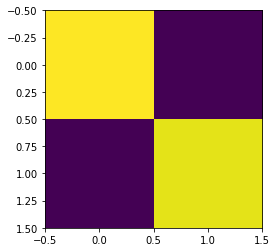

In [39]:
# for nn in [5, 10, 15]:
for nn in [15]:
    print ('knn with ', nn, ' neighbors')
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn_me = testClassifier(train_tfmat, train_lbl, test_tfmat, test_lbl, knn)
    metrics_dict.append({'name':'5NN', 'metrics':knn_me})
    print (' ')

NearestCentroid - Rocchio
training time:  0:00:00.010231
testing time:  0:00:00.002099
classification report: 
                         precision    recall  f1-score   support

comp.os.ms-windows.misc       1.00      1.00      1.00        50
     rec.sport.baseball       1.00      1.00      1.00        48

               accuracy                           1.00        98
              macro avg       1.00      1.00      1.00        98
           weighted avg       1.00      1.00      1.00        98

f1 score
1.0
accuracy score
1.0
confusion matrix:
[[50  0]
 [ 0 48]]


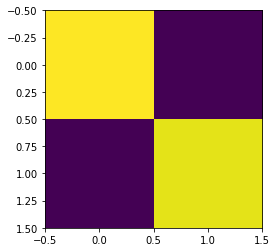

In [58]:
print ('NearestCentroid - Rocchio')
model = NearestCentroid() 
NearestCentroid_me= testClassifier(train_tfmat, train_lbl, test_tfmat, test_lbl, model)
metrics_dict.append({'name':'NearestCentroid', 'metrics':NearestCentroid_me})
print (' ')


In [59]:
print (metrics_dict)


[{'name': '5NN', 'metrics': [datetime.timedelta(0, 0, 1972), datetime.timedelta(0, 0, 10378), 0.8596491228070176, 0.98, 0.975609756097561, 0.8333333333333334, 0.9073821274808358]}, {'name': '5NN', 'metrics': [datetime.timedelta(0, 0, 2473), datetime.timedelta(0, 0, 14130), 0.98, 0.98, 0.9791666666666666, 0.9791666666666666, 0.9795833333333333]}, {'name': 'NearestCentroid', 'metrics': [datetime.timedelta(0, 0, 7091), datetime.timedelta(0, 0, 1637), 1.0, 1.0, 1.0, 1.0, 1.0]}, {'name': 'NearestCentroid', 'metrics': [datetime.timedelta(0, 0, 10231), datetime.timedelta(0, 0, 2099), 1.0, 1.0, 1.0, 1.0, 1.0]}]
